In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from nc4 import *

# seaborn.set_theme()

In [3]:
print_variable_metadata("MERRA2_100.tavg3_3d_cld_Np.19800101.nc4", "RH")


[21:26:01] LOG: Loading compressed/RH/MERRA2_100.tavg3_3d_cld_Np.19800101.nc4
<xarray.Dataset>
Dimensions:  (time: 8, lev: 42, lat: 361, lon: 288)
Dimensions without coordinates: time, lev, lat, lon
Data variables:
    RH       (time, lev, lat, lon) float32 ...


In [4]:
def load_nc4_to_dataframe(filename: str, variable: str) -> pd.DataFrame:
    with open_xarray_dataset(filename, folder=f"compressed/{variable}") as dataset:
        packed_data = dataset.to_dataframe()[variable].array

    unpacked_data = packed_data.view("float16").astype("float16")
    dataframe = pd.DataFrame({variable: unpacked_data})

    with pd.option_context('mode.use_inf_as_na', True):
        dataframe.dropna(how="all", inplace=True)

    return dataframe


def load_variable_at_time_and_level(filename: str, variable: str, time: int, level: int = 0) -> np.array:
    with open_xarray_dataset(filename, folder=f"compressed/{variable}") as dataset:
        data = np.array(dataset[variable][time][level])

    data = data.view("float16").astype("float16")
    # data = np.nan_to_num(data, posinf=0)
    return data

In [5]:
def plot_contour_at_time_and_level(filename: str, variable: str, time: int, level: int = 0) -> None:
    data = load_variable_at_time_and_level(filename, variable, time, level)

    plt.contourf(data)
    plt.show()

[21:26:05] LOG: Loading compressed/RH/MERRA2_100.tavg3_3d_cld_Np.19800101.nc4


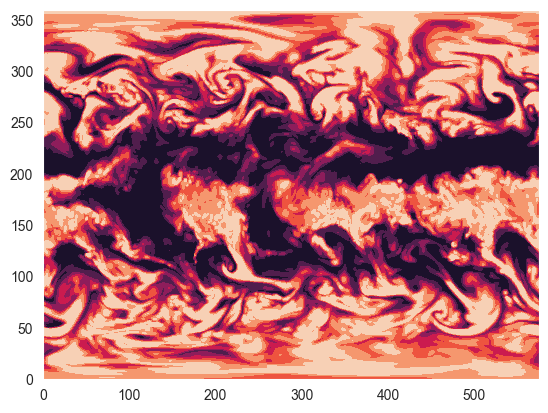

In [6]:
plot_contour_at_time_and_level("MERRA2_100.tavg3_3d_cld_Np.19800101.nc4", "RH", time=0, level=16)
